# Topic modeling 21.05.2021

#### План на сегодня:
- Постановка задачи на сегодня
- Что мы будем использовать и какие есть альтернативы
- Что такое тематическое моделирование
- Какие шаги нужно предпринять
- Предобработка текста
    - зачем это нужно
    - лемматизация/стемминг
    - векторизация
- Как устроенно тематическое моделирование на примере Latent Semantic Analysis
- Оценка качества
- Практика на примере sklearn и роспотребнадзора
    - Предобработка текста
    - Построение моделей
    - Объекты моделей
    - Оценка тем
- Визуализация

---

## Постановка задачи на сегодня

Наша цель оценить на, жалются люди в Роспотреб надзор. 
<pre>
https://zpp.rospotrebnadzor.ru/Forum/Appeals/
</pre>

При этом нам нельзя читать "вручную". Нам хочется, посмотреть на "график тем".

---

## Что мы будем использовать и какие есть альтернативы

Мы будем использовать:
- Пакеты
    - sklearn
    - spacy
- Модели:
    - Latent Semantic Analysis
    - Non-Negative Matrix Factorization
    - Latent Dirichlet Allocation
- Визуализация:
    - matplotlib
- Оценка моделей:
    - вручную

Что мы **не** будем сегодня использовать (но обязательно посмотрите сами):
- Пакеты:
    - gensim
    - bigArtm
- Модели:
    - Mallet
    - Artm
    - HDP
    - PLSA
- Визуализация:
    - pyLDAviz
    - plotly
    - и многое другое
- Оценка моделей:
    - perplexity 
    - UCI
    - UMass
  
  

  


Зависимости для сегодняшнего занятия:

In [23]:
!pip list | grep "requests\|bs4\|tqdm\|spacy\|sklearn\|matplotlib\|umap\|pandas\|numpy"

bs4                      0.0.1
matplotlib               3.3.4
numpy                    1.20.3
pandas                   1.2.4
requests                 2.25.1
requests-oauthlib        1.3.0
sklearn                  0.0
spacy                    3.0.6
spacy-legacy             3.0.5
tqdm                     4.60.0
umap-learn               0.5.1


## Что такое тематическое моделирование

Тематическое моделирование - это вид машинного обучения без учителя (Unsupervised learning). Это означает, у вас есть только корпус документов **(X)**, но нет меток **(Y)**.  

![](1.png)

*Цель тематического моделирование* - выделить "топики" в документах. 

*Топик* - это абстракная сущность, которая представлена нам в виде набора слов. 

*Наша цель* - из корпуса текстов выделить темы, которые там представлены, и каждому документу сопоставить тему. 

*Корпус* - это набор текстов.

*Документ* - это отдельный текст. Дальше мы будем придерживаться этой терминологии.

## Какие шаги нужно предпринять

![](2.png)

1) Найти и скачать данные.
2) Предобработка данных. 
3) Построение модели
4) Оценка результатов

### Найти и скачать данные

In [3]:
import requests
from bs4 import BeautifulSoup 
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm

import pickle 

In [37]:
## найти id каждого вопроса на страницах
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]
    
urls = []
for page in tqdm(range(1, 200), desc='Pages'):
    time.sleep(0.5)
    res = requests.get(main_url.format(page=page))  
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))

Pages:   0%|          | 0/199 [00:00<?, ?it/s]

In [54]:
## имея id запросов достанем тексты на страницах
domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text
def get_text_page_answer(soup):
    return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

question = []
answers = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.5)
    res = requests.get(urljoin(domain, url))  
    soup = BeautifulSoup(res.text)
    
    question.append(get_text_page_question(soup))
    try:
        answers.append(get_text_page_answer(soup))
    except:
        answers.append('No answer')

Pages:   0%|          | 0/995 [00:00<?, ?it/s]

In [55]:
# сохранить в виде сериализованного объекта
with open('qa_rospotreb_nadzor', 'wb') as f:
    pickle.dump((question, answers), f)

In [6]:
## подгрузить сериализованый объект
import pickle 
with open('./LDA_2021/qa_rospotreb_nadzor', 'rb') as f:
    question, answers = pickle.load(f)

In [28]:
## посмотрим, что скачалось
N = 6
print('Q:', question[N])
print()
print('A:', answers[N])

Q: Здравствуйте! Прошу разобраться с компанией Сити Мобил, лешить их лицензии т. к водители грубияны хамы произшошла ситуация вызвали такси в аэропорт Шереметьево с города Одинцово, водитель не захотел ехать устроил скандал угродал на полдороги и высадил нас на Можайском шоссе около дома 45 прям на трассе и сказал как хотите так и добирайтесь он был в неадыкваьном состоянии. В результате опоздыаали на рейс и еле уехали с трассы. На каком основании нам высадили из такси силой. 

A: Добрый день! В данной ситуации заявление,фото/аудио/видио направить в ГУ МВД РФ по Московской области и Прокуратуру Московской области. Данный вопрос не входит в полномочия Роспотребнадзора


### Предобработка данных

Типичная предобработка данных включает в себя следующие шаги:
- Токенизация
- Удаление стоп слов
- Стемминг/лемматизация
- Векторизация

#### Токенизация

Разбиние изначально целого текста, на составные части - токены. 

Токеном может быть: 
- Предложение
- Слово
- Символ
- Документ
- Биграммы, триграммы и пр.

Это гранулярность нашего интереса

Пример на примере пакета spacy:

In [53]:
# !pip uninstall spacy
# !pip install -U spacy
# !python -m spacy download ru_core_news_sm

import spacy ## общий пакет, где лежит весь функционал
import ru_core_news_sm ## натренированные модели на русском
import string ## здесь возомьм пунктуацию
import nltk # удобный пакет для всякой работы с текстом

In [126]:
text = question[10]
print(text)

Здравствуйте! Я Баимова Светлана Игоревна, открыла личевой счет в Газпромбанке, где я получаю детские пособия. Но Газпромбанк у меня удерживают 50% и отправляют пристовам. Вот смотрите!!! И арест с карты не снимают чтоб я снила детские. На карту мир. 


In [127]:
nlp = ru_core_news_sm.load() ## умная "обертка" для каждого текста
doc = nlp(text)
doc

Здравствуйте! Я Баимова Светлана Игоревна, открыла личевой счет в Газпромбанке, где я получаю детские пособия. Но Газпромбанк у меня удерживают 50% и отправляют пристовам. Вот смотрите!!! И арест с карты не снимают чтоб я снила детские. На карту мир. 

In [47]:
tokenized1 = [token for token in doc] # первый способ
tokenized2 = text.split(' ') # второй способ

В чем их отличия?

In [54]:
## еще способы
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()

#### Удаление стоп слов

Стоп слова - это слова, которые мешают в анализе. К примеру слишком популярные слова или наоборот слишком редкие.
Также, часто к стоп словам относят:
- знаки препинания
- специальные символы
- иностранные язык
- цифры

In [55]:
from spacy.lang.ru.stop_words import STOP_WORDS # стоп слова
[token for token in doc if token not in STOP_WORDS]

[Здравствуйте,
 ,,
 помогите,
 пожалуйста,
 разобраться,
 в,
 следующей,
 ситуации,
 .,
 Купили,
 телевизор,
 в,
 магазине,
 ДНС,
 ,,
 на,
 следующий,
 день,
 оказалось,
 ,,
 что,
 невозможно,
 настроить,
 каналы,
 ,,
 позвонили,
 на,
 горячую,
 линию,
 ,,
 нам,
 предложили,
 самостоятельно,
 ехать,
 в,
 сервисный,
 центр,
 .,
 11,
 мая,
 телевизор,
 сдали,
 в,
 магазин,
 на,
 экспертизу,
 ,,
 обменять,
 или,
 вернуть,
 деньги,
 в,
 магазине,
 отказались,
 ,,
 сославшись,
 на,
 то,
 ,,
 что,
 это,
 технически,
 сложный,
 товар,
 .,
 Прав,
 ли,
 продавец,
 ?]

#### Стемминг/лемматизация

Оба слова означают приведение определенного слова к его основе (лемме). Они различаются только подходом.

Стемминг - это алгоритм, которые по опредленным правилам отсекает ненужные буквы в слове
Лемматизация - это метод, которые работает на большой базе словаре.

Выход у обоиз методов одинаковый. 


![](porterstemmer.png)

In [56]:
## Варинаты nltk
stemmer = nltk.stem.PorterStemmer()
#" ".join(stemmer.stem(token) for token in tokens)
lemmatizer = nltk.stem.WordNetLemmatizer()
#" ".join(lemmatizer.lemmatize(token) for token in tokens)

In [64]:
## spacy 
doc = nlp(text)
doc[2].lemma_

'помочь'

##### Соберем все вместе:

In [69]:
# Parser for reviews
punctuations = string.punctuation
stopwords = STOP_WORDS

def spacy_processor(sentence):
    mytokens = nlp(sentence)
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens
spacy_processor(text)

'здравствовать баимов светлана игоревич открыть личевой счёт газпромбанк где получать детский пособие газпромбанк удерживать 50 отправлять пристовам смотреть арест карта снимать чтоб снила детский карта мир'

In [71]:
text_data = [spacy_processor(text) for text in tqdm(question)]

  0%|          | 0/995 [00:00<?, ?it/s]

##### Как еще можно почистить тексты:

In [68]:
doc = nlp(text)
spacy.displacy.render(doc, style='ent', jupyter=True)

#### Векторизация

Это процесс превращения текста в вектор. Главная цель максимально передать смысл предложения.

![](bow.jpeg)

или так:

![](tfidf.jpeg)

или даже так:

![](doc2vec.png)

Мы для простоты и надежности остановимся на первом варианте:

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

vectorizer = CountVectorizer(ngram_range=(2,2), # биграммы
                             max_df=20, # верхний порого встречаемости 
                             min_df=3, # нижний порого встречаемости
                             max_features=5000) ## размер выходного вектора

data_vectorized = vectorizer.fit_transform(text_data)

In [75]:
data_vectorized[0].todense().shape

(1, 2309)

### Тематическое моделирование

Что у нас есть на входе:

![](4.png)

In [81]:
import pandas as pd
pd.DataFrame(data_vectorized.todense(), 
             columns=vectorizer.get_feature_names())

Что мы хотим получить:

![](5.png)

Что лежит в основе такого предобразования? То же, что в основании рекомендательных систем - матричное разложение. В случае вверху это SVD - singular value decomposition

$$M = U \times\Sigma\times V^T$$

- $M$ doc-term матрица
- $U$ doc-topic матрица
- $\Sigma$ topic-topic матрица
- $V^T$ topic-term матрица

Еще пример:

![](init.png)

![](decopm.png)

![](deux.png)

In [82]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF

NUM_TOPICS = 10

# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, 
                                max_iter=10, 
                                learning_method='online', 
                                verbose=True)
data_lda = lda.fit_transform(data_vectorized)

# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [85]:
data_lsi.shape

(995, 10)

In [86]:
lsi.components_.shape

(10, 2309)

In [93]:
def print_topics(model, vectorizer, n_words=10):
    for idx, topic in enumerate(model.components_):
        print()
        print(f'Topic {idx}:', [(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-n_words - 1:-1]]) 

In [94]:
print_topics(lsi, vectorizer)


Topic 0: [('tikets ru', 0.21991908417768286), ('компания аэрофлот', 0.1762905595583588), ('su555rasqag 202103050528', 0.1759352673421463), ('москва ираклион', 0.1759352673421463), ('ираклион москва', 0.1759352673421463), ('tickets ru', 0.13221769637495911), ('номер билет', 0.13195145050660972), ('202103050528 казань', 0.13195145050660972), ('2126 ираклион', 0.13195145050660972), ('москва казань', 0.13195145050660972)]

Topic 1: [('февраль 2021', 0.31386380127971597), ('12 февраль', 0.15410212748516333), ('январь 2021', 0.1045359905026405), ('21 день', 0.1028267353036615), ('центр apple', 0.102809806923052), ('15 февраль', 0.10235037851749725), ('отправить москва', 0.10225927875675832), ('23 январь', 0.10225927875675832), ('аппарат находиться', 0.10225927875675832), ('аппарат снова', 0.10225927875675832)]

Topic 2: [('краснодарский край', 0.5220503975058877), ('александр усольцев', 0.21380855459605422), ('17 12', 0.18493954883347533), ('15 03', 0.14654798619356094), ('ваш ведомство', 0

#### Можем ли мы использовать нашу модель для того, чтобы предсказывать?

Конечно.

In [104]:
import numpy as np
new_text = 'привет как дела'
new_corpus = [new_text]

new_vectorized = vectorizer.transform(new_corpus)

In [106]:
np.argmax(lsi.transform(new_vectorized))

0

## Визуализация

In [107]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap
import random
import pandas as pd

number_of_colors = NUM_TOPICS

reducer_umap = umap.UMAP(n_components=2, random_state=42)
reducer_tsne = TSNE(n_components=2, random_state=42)

reduced_umap = reducer_umap.fit_transform(data_vectorized)
reduced_tsne = reducer_tsne.fit_transform(data_vectorized)

In [118]:
x_umap = reduced_umap.T[0]
y_umap = reduced_umap.T[1]

x_tsne = reduced_tsne.T[0]
y_tsne = reduced_tsne.T[1]

label = np.argmax(data_nmf, axis=1)

color_map = dict(enumerate(['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]))

In [119]:
source = pd.DataFrame({'x_umap': x_umap, 
                       'y_umap': y_umap,
                       'x_tsne': x_tsne,
                       'y_tsne': y_tsne,
                       'topic': label
                      })
source['color'] = source.topic.map(color_map)

In [120]:
source.head()

,x_umap,y_umap,x_tsne,y_tsne,topic,color
0,7.631234,8.388699,-0.846545,-11.265906,8,#70EC11
1,3.182832,8.437605,-3.450348,-4.149593,8,#70EC11
2,6.842889,7.328386,-8.798013,4.660034,6,#626C18
3,8.338409,9.919741,1.777348,-4.042747,8,#70EC11
4,7.442799,9.996269,3.689503,-10.905416,6,#626C18


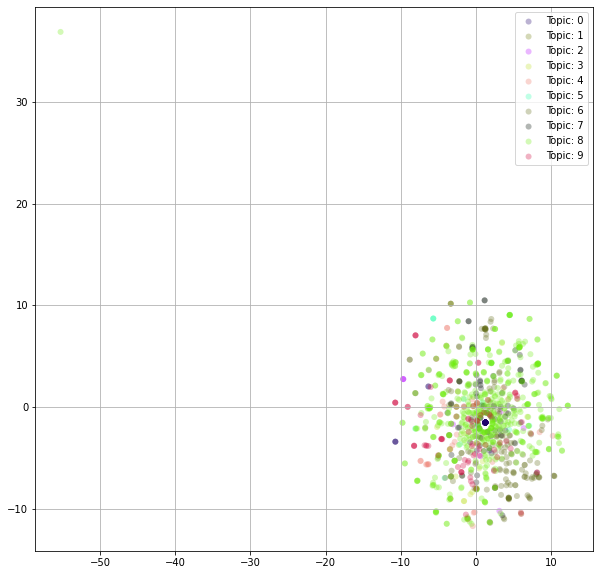

In [121]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
for n, color in enumerate(color_map.values()):
    
    data_vis = source[source['color']==color].copy() ## данные только с этим цветом
    
    ax.scatter(data_vis['x_tsne'], 
               data_vis['y_tsne'], 
               c=color, 
               label=f'Topic: {n}', 
               alpha=0.3, 
               edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

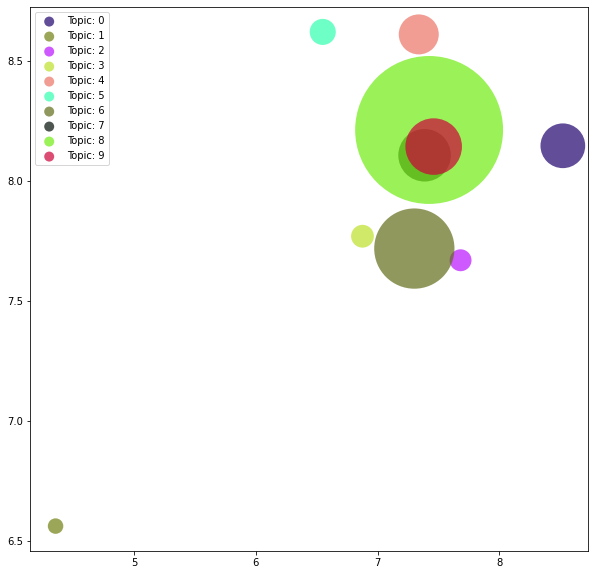

In [125]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
for n, color in enumerate(color_map.values()):
    
    data_vis = source[source['color']==color].copy() ## данные только с этим цветом
    x = data_vis.x_umap.mean()
    y = data_vis.y_umap.mean()
    s = data_vis.shape[0]
    ax.scatter(x, 
               y, 
               c=color, 
               label=f'Topic: {n}',
               s=s*40,
               alpha=0.7, 
               edgecolors='none')

#ax.legend(loc='lower left', prop={'size': 10}, fontsize=20)
lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=10)
for leg in range(NUM_TOPICS):
    lgnd.legendHandles[leg]._sizes = [100]

#ax.grid(True)

plt.show()

In [123]:
print_topics(nmf, vectorizer)


Topic 0: [('tikets ru', 1.3799917918084799), ('компания аэрофлот', 1.1061695929159212), ('москва ираклион', 1.103993433446784), ('ираклион москва', 1.103993433446784), ('su555rasqag 202103050528', 1.103993433446784), ('tickets ru', 0.829620531247048), ('su1199 москва', 0.8279950750850882), ('бронирование su555rasqag', 0.8279950750850882), ('москва казань', 0.8279950750850882), ('москва su2127', 0.8279950750850882)]

Topic 1: [('февраль 2021', 1.8222064646351845), ('12 февраль', 0.8965315542701194), ('январь 2021', 0.6057660609653494), ('центр apple', 0.5980563472690688), ('21 день', 0.5972467302422739), ('15 февраль', 0.5955395875880973), ('23 январь', 0.5950791900122135), ('отправить москва', 0.5950791900122135), ('асц воронеж', 0.5950791900122135), ('аппарат снова', 0.5950791900122135)]

Topic 2: [('краснодарский край', 2.4903063516232944), ('александр усольцев', 1.020605095320337), ('17 12', 0.8824944956749138), ('15 03', 0.6990059684414512), ('ваш ведомство', 0.6977533662909877), 